<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Ensemble Learning. </center></h2>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

## Task 1

Load data from `data/x_data.tsv` and `data/y_data.tsv`. 

These are descriptive features and target feature. Put them in `X` and `y` respectively.

In [11]:
df_X = pd.read_csv('./data/x_train.csv', sep=';')
df_y = pd.read_csv('./data/y_train.csv', sep=';', header=None,
                  names=['target'])

In [12]:
df_X.head()
df_y.head()

,target
0,0
1,1
2,1
3,1
4,0


In [13]:
df_X.shape

(25289, 12)

In [14]:
df_y.shape

(25289, 1)

In [15]:
X = df_X.values
y = df_y.values

## Task 2

Plot validation curve w.r.t. hyperparameter `max_depth` of Decistion Tree? Which depth deliveres the best roc-auc?

In [16]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier


In [17]:
model = DecisionTreeClassifier()
cv = StratifiedKFold(5, shuffle=True, random_state=123)

In [21]:
depth_range = range(1, 11)
train_scores, test_scores = \
validation_curve(model, X, y, 'max_depth', depth_range, 
                 cv=cv, scoring='roc_auc')

In [23]:
tree_scores = test_scores.mean(axis=1)

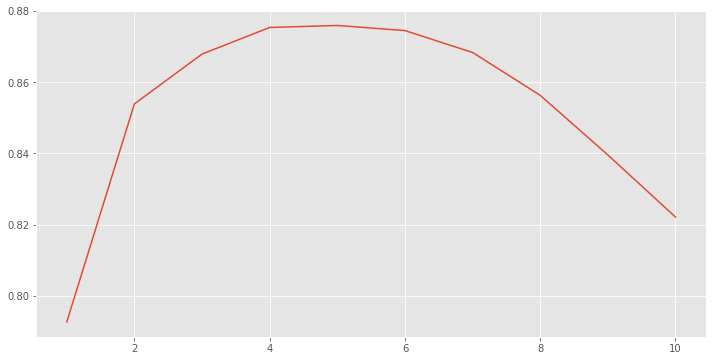

In [25]:
plt.plot(depth_range, tree_scores)

## Task 3

Wrap DecTree in to BaggingClasifier. Repeat the same procedure with `max_depth`. 

What are you observing? Is quality better?

HINT: to iterate over base_estimator's hyperparameters use `"base_estimator__"` prefix in `param_name` argument of `validation curve`

In [26]:
from sklearn.ensemble import BaggingClassifier

In [27]:
model = BaggingClassifier(DecisionTreeClassifier(), 
                          random_state=123,
                          n_estimators=100)

In [28]:
train_scores, test_scores = \
validation_curve(model, X, y, 'base_estimator__max_depth', 
                 depth_range, 
                 cv=cv, scoring='roc_auc')

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
bagging_scores = test_scores.mean(axis=1)

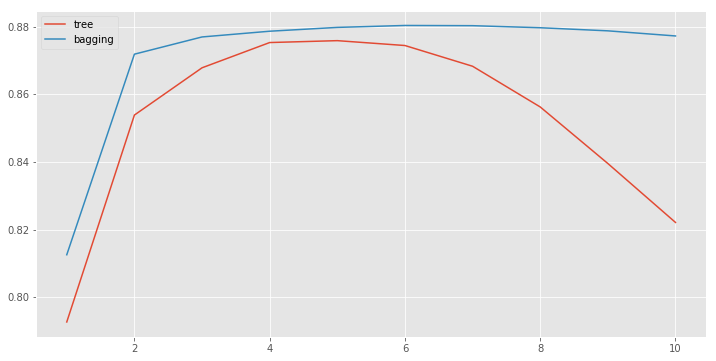

In [31]:
plt.plot(depth_range, tree_scores, label='tree')
plt.plot(depth_range, bagging_scores, label='bagging')
plt.legend()

## Task 4

Now consider RandomForestClassifier. Repeat the same actions with it

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [34]:
train_scores, test_scores = \
validation_curve(model, X, y, 'max_depth', 
                 depth_range, 
                 cv=cv, scoring='roc_auc')

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [35]:
forest_scores = test_scores.mean(axis=1)

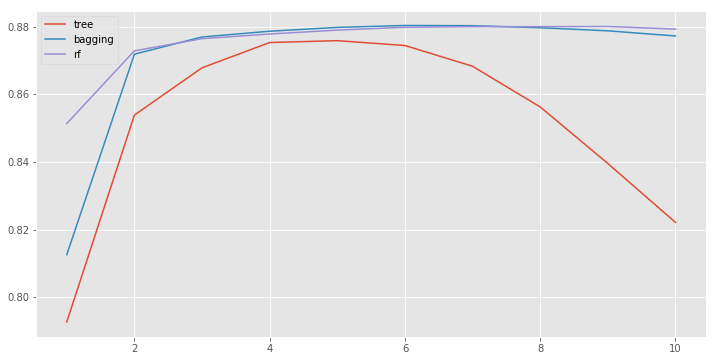

In [36]:
plt.plot(depth_range, tree_scores, label='tree')
plt.plot(depth_range, bagging_scores, label='bagging')
plt.plot(depth_range, forest_scores, label='rf')
plt.legend()

## Task 5

Tree leaves can be considered as categorical features:

* Train forest with $T$ trees on your data
* Enumerate leaves of each tree from $0$ to $L_T$
* Each object would have feature "a which leaf it ended up" for each tree
* Encode those with OHE
* Profit??

Any doubts?

In [37]:
from sklearn.ensemble import RandomTreesEmbedding

In [50]:
emb = RandomTreesEmbedding(n_estimators=10, 
                           max_depth=5, 
                           random_state=123)
emb.fit(X)

# emb = RandomForestClassifier(n_estimators=10, 
#                              max_depth=5, 
#                              random_state=123)
# emb.fit(X, y)

RandomTreesEmbedding(max_depth=5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=123, sparse_output=True, verbose=0,
           warm_start=False)

In [51]:
X_emb = emb.apply(X)

In [52]:
X_emb.shape

(25289, 10)

In [53]:
X_emb[:10]

array([[15, 15, 12, 31,  5,  5,  6,  5, 15, 18],
       [23, 15, 15, 31,  5, 23,  6,  5, 15, 39],
       [15,  5,  9, 31,  8,  5,  5, 41,  8,  6],
       [ 8,  5, 12,  5,  5,  5,  5,  5,  5,  5],
       [15,  5,  8, 31,  8,  5,  5, 41,  8,  6],
       [ 5,  5,  5, 12,  5,  5,  5,  5,  5,  5],
       [15,  5, 12, 31,  9,  5,  6,  5,  8, 18],
       [15,  5, 12, 31,  5,  5,  6,  5,  5, 18],
       [ 8,  5,  5, 30,  5,  5,  5,  5,  5,  5],
       [ 5, 12,  6, 30,  5,  5,  5,  5, 12,  5]])

In [54]:
X_emb_sparse = emb.transform(X)

In [55]:
X_emb_sparse

<25289x224 sparse matrix of type '<type 'numpy.float64'>'
	with 252890 stored elements in Compressed Sparse Row format>

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [67]:
model = Pipeline([
    ('tree_emb', RandomTreesEmbedding(n_estimators=50, 
                                      max_depth=4)),
    ('clf', LogisticRegression(C=0.1))
])

simple_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=0.1))
])


In [69]:
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores.mean()

0.87771098618873644

In [70]:
scores = cross_val_score(simple_model, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
scores.mean()

0.87350068593499175

# Task 6 (staking)

In [71]:
!pip install vecstack

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [72]:
from vecstack import stacking

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

In [76]:
models = [
    RandomForestClassifier(n_estimators=50, 
                           max_depth=5, 
                           random_state=123),
    RandomForestClassifier(n_estimators=50, 
                           max_depth=10, 
                           random_state=123, 
                           max_features='log2'),
    Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=11))
    ]),
    GaussianNB(),
    DummyClassifier(random_state=123),
    DummyClassifier(random_state=321)
]

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=123, 
                                                      test_size=0.2)

In [82]:
from sklearn.metrics import roc_auc_score

In [83]:
def roc_auc_score_cust(y_true, y_hat):
    return roc_auc_score(y_true, y_hat[:,1])

In [84]:
S_train, S_valid = stacking(models,
                               X_train, y_train, X_valid,
                               regression=False,
                               mode='oof_pred_bag', 
                               needs_proba=True,
                               metric=roc_auc_score_cust,
                               n_folds=5,                
                               stratified=True,          
                               shuffle=True,             
                               random_state=123,         
                               verbose=2)                

task:       [classification]
n_classes:  [2]
metric:     [roc_auc_score_cust]
mode:       [oof_pred_bag]
n_models:   [7]

model 0:    [RandomForestClassifier]
    fold 0: [0.88177273]
    fold 1: [0.88243647]
    fold 2: [0.88676255]
    fold 3: [0.87102158]
    fold 4: [0.87560107]
    ----
    MEAN:   [0.87951888] + [0.00554285]
    FULL:   [0.87920882]

model 1:    [RandomForestClassifier]
    fold 0: [0.88206891]
    fold 1: [0.88025162]
    fold 2: [0.88633036]
    fold 3: [0.87063865]
    fold 4: [0.87612213]
    ----
    MEAN:   [0.87908234] + [0.00534564]
    FULL:   [0.87890000]

model 2:    [Pipeline]
    fold 0: [0.87752342]
    fold 1: [0.87690061]
    fold 2: [0.88109687]
    fold 3: [0.86698334]
    fold 4: [0.86898332]
    ----
    MEAN:   [0.87429751] + [0.00538798]
    FULL:   [0.87421594]

model 3:    [Pipeline]
    fold 0: [0.86252076]
    fold 1: [0.85394339]
    fold 2: [0.86405013]
    fold 3: [0.84406811]
    fold 4: [0.86272581]
    ----
    MEAN:   [0.85746164]

In [88]:
S_train.shape

(20231, 14)

In [89]:
S_valid.shape

(5058, 14)

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

In [92]:
last_model = GradientBoostingClassifier(n_estimators=300, 
                                        max_depth=3,
                                        learning_rate=0.01, 
                                        random_state=123)

In [93]:
last_model.fit(S_train, y_train)
y_hat = last_model.predict_proba(S_valid)
roc_auc_score(y_valid, y_hat[:, 1])

0.8749437180004922

In [94]:
last_model.feature_importances_

array([  1.89939693e-01,   1.82002522e-01,   1.11852754e-01,
         1.19056521e-01,   1.29605196e-01,   1.33530708e-01,
         4.48717241e-02,   5.60964093e-02,   1.39145963e-02,
         1.88583282e-02,   0.00000000e+00,   0.00000000e+00,
         1.70606450e-04,   1.00941873e-04])

In [95]:
for model in models:
    last_model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_valid)
    score = roc_auc_score(y_valid, y_hat[:, 1])
    print('{}: {}'.format(model.__str__().split('(')[0], score))

RandomForestClassifier: 0.874084885633
RandomForestClassifier: 0.874530693224
Pipeline: 0.868954616981
Pipeline: 0.849414609182
GaussianNB: 0.799907724598
DummyClassifier: 0.500905153807
DummyClassifier: 0.509098536436
